In [89]:
import os
import pandas as pd
import numpy as np
import earthpy as et

In [90]:
curr_timespan = '2014to2023'

fire_dir = os.path.join(et.io.HOME, 'earth-analytics', 'EA_fire_project')
data_dir = os.path.join(fire_dir, 'data')
out_dir = os.path.join(data_dir, 'original')
tmp_dir = os.path.join(data_dir, 'processed')

In [92]:
df = pd.read_csv(os.path.join(out_dir,
                                  'SIT209_HISTORY_INCIDENT_209_REPORTS_{}_cleaned.csv'.format(curr_timespan)), 
                     parse_dates=True,
                     low_memory=False)
# Remove unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [93]:
df['PCT_CONTAINED_COMPLETED']

0         100.0
1          99.0
2           0.0
3           0.0
4           0.0
          ...  
100584      0.0
100585     60.0
100586     80.0
100587     80.0
100588    100.0
Name: PCT_CONTAINED_COMPLETED, Length: 100589, dtype: float64

In [95]:
columns = ['INCIDENT_ID',
           'INC209R_IDENTIFIER',
           'REPORT_TO_DATE',
           'CURRENT_THREAT_12',
           'CURRENT_THREAT_24',
           'CURRENT_THREAT_48',
           'CURRENT_THREAT_72',
           'CURRENT_THREAT_GT72',
           'CURRENT_THREAT_NARR',
           'STR_THREATENED_RES',
           'STR_THREATENED',
           'STR_DESTROYED',
           'LIFE_SAFETY_HEALTH_STATUS_NARR',
           'PCT_CONTAINED_COMPLETED']
# create a subset of the data
dfsub = df.loc[
    df.INCIDENT_ID.isin(
        ['2021_12993824_DIXIE','2021_12908560_CALDOR'])][columns].copy()
# Fill empty values with ''
collist = ['CURRENT_THREAT_12',
           'CURRENT_THREAT_24',
           'CURRENT_THREAT_48',
           'CURRENT_THREAT_72',
           'CURRENT_THREAT_GT72']
dfsub[collist] = dfsub[collist].fillna('')

In [96]:
df_norepeat = dfsub.copy()

for col in collist:
    # create a new column that shifts the current column down by one row
    df_norepeat['shifted'] = df_norepeat[col].shift(1)
    
    # Compare the current column with 'shifted'.
    new_col_name = f'unrepeated_{col}'
    df_norepeat[new_col_name] = (
        df_norepeat.apply(lambda row: 'same' if row[col] == row['shifted'] else row[col],
                    axis=1)
    )
    
    # Drop the temporary 'shifted' column after use
    df_norepeat.drop(columns=['shifted'], inplace=True)

In [97]:
df_norepeat['REPORT_TO_DATE']

# Convert 'REPORT_TO_DATE' to datetime format
df_norepeat['REPORT_TO_DATE'] = pd.to_datetime(df_norepeat['REPORT_TO_DATE'])

# Sort the DataFrame by 'REPORT_TO_DATE'
df_norepeat = df_norepeat.sort_values('REPORT_TO_DATE')

# Calculate the difference in hours and add as a new column
df_norepeat['last_reported'] = df_norepeat['REPORT_TO_DATE'].diff().dt.total_seconds() / 3600

<Axes: title={'center': 'Time between reports (hours)'}, ylabel='Frequency'>

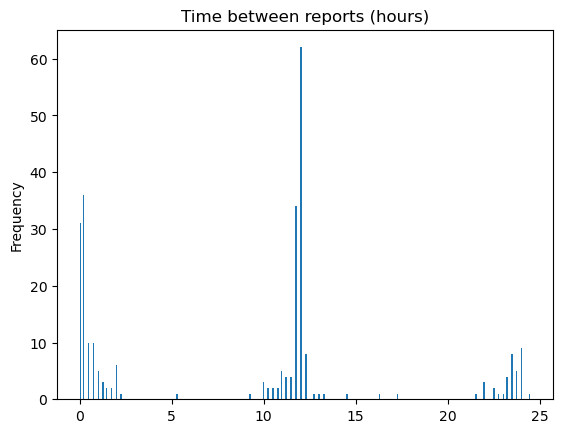

In [98]:
# time between reports in general
# could also be interesteing time between new 12 hours threats
# 12 hours threat has the least uncertainty? 12 hour lead time?
df_norepeat['last_reported'].plot(kind='hist', bins= len(df_norepeat), title='Time between reports (hours)')

80410      0.0
80411      0.0
80412      7.0
80413      7.0
80414      7.0
         ...  
77682    100.0
80579     97.0
80580     97.0
80581     97.0
80582    100.0
Name: PCT_CONTAINED_COMPLETED, Length: 276, dtype: float64

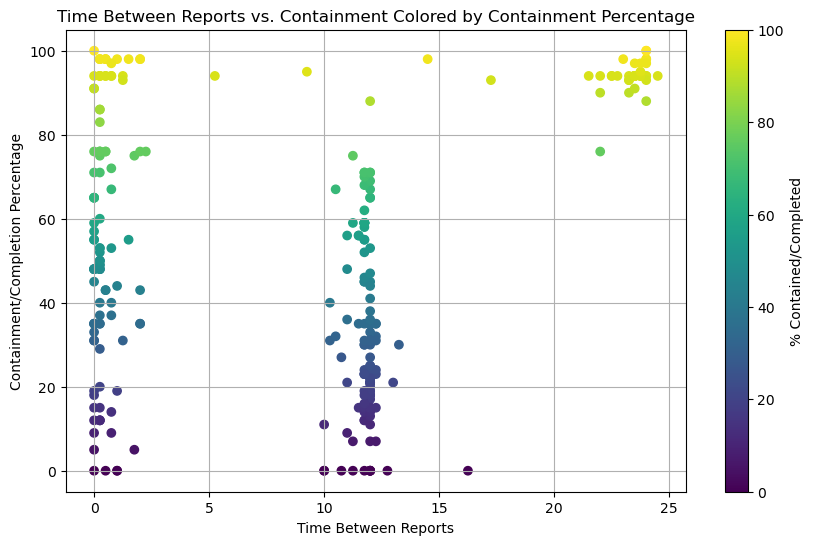

In [101]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and it has columns 'time_between_reports' and 'final_fire_size'
# Load your data into a DataFrame
# df = pd.read_csv('your_data.csv')  # Uncomment and modify this line as necessary

# Ensure the data is numeric (this step may vary depending on your data)
df_norepeat['last_reported'] = pd.to_numeric(df_norepeat['last_reported'], errors='coerce')
df_norepeat['PCT_CONTAINED_COMPLETED'] = pd.to_numeric(df_norepeat['PCT_CONTAINED_COMPLETED'], errors='coerce')

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
scatter = plt.scatter(df_norepeat['last_reported'],
                      df_norepeat['PCT_CONTAINED_COMPLETED'], 
                      c=df_norepeat['PCT_CONTAINED_COMPLETED'], cmap='viridis')

# Add a color bar
plt.colorbar(scatter, label='% Contained/Completed')

# Customize the plot
plt.xlabel('Time Between Reports')
plt.ylabel('Containment/Completion Percentage')
plt.title('Time Between Reports vs. Containment Colored by Containment Percentage')
plt.grid(True)  # Optional: Adds a grid for easier visualization

# Show the plot
plt.show()

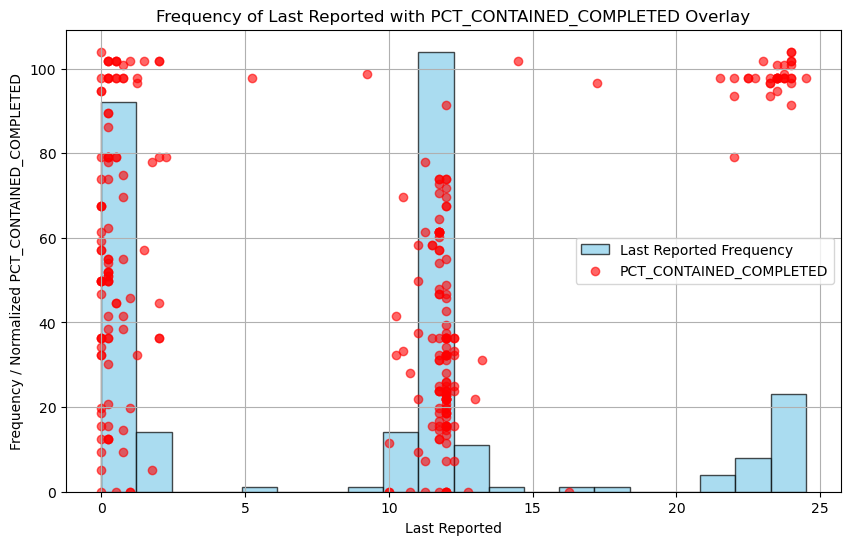

In [103]:
import numpy as np

# Create the histogram for 'last_reported'
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_norepeat['last_reported'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Last Reported Frequency')

# Normalize 'PCT_CONTAINED_COMPLETED' to match the histogram's y-axis scale
# This step is crucial to overlaying the scatter plot meaningfully on the histogram
max_height = max(n)  # Maximum frequency in the histogram
normalized_pct = (df_norepeat['PCT_CONTAINED_COMPLETED'] / df_norepeat['PCT_CONTAINED_COMPLETED'].max()) * max_height

# Create the scatter plot overlay
plt.scatter(df_norepeat['last_reported'], normalized_pct, color='red', label='PCT_CONTAINED_COMPLETED', alpha=0.6)

# Customize the plot
plt.xlabel('Last Reported')
plt.ylabel('Frequency / Normalized PCT_CONTAINED_COMPLETED')
plt.title('Frequency of Last Reported with PCT_CONTAINED_COMPLETED Overlay')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [51]:
# Calculate the percentage of repeated/unrepeated values
(df_norepeat['unrepeated_CURRENT_THREAT_12'] == 'same').sum() / len(df_norepeat)
(df_norepeat['unrepeated_CURRENT_THREAT_12'] != 'same').sum() / len(df_norepeat)

0.45652173913043476

In [26]:
dft = dfsub.copy()
# strip spaces
for col in collist:
    dft[col] = df[col].str.strip()

# initialize appended to False and consolidated narrative to empty string
dft['CURRENT_THREAT_NARR2'] = ''
for col in collist:
    time_frame = col.split('_')[-1]
    # strip to make sure not null
    if time_frame == '12':
        # initialize processed content
        dft.loc[dft[col] != '','prev_narr'] = dft['CURRENT_THREAT_12']
        dft.loc[dft[col] != '','time_label'] = time_frame
    else: 
        # later time_frame
        # equal to previous narrative - add time to time label
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() == dft['prev_narr'].str.lower()),
            'time_label'
            ]= dft.time_label + '/' + time_frame
        # not equal - append and re-initialize
        dft.loc[
            ((dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower())),
            'CURRENT_THREAT_NARR2'
            ] = dft.CURRENT_THREAT_NARR2 + \
                "\n" + dft.time_label + " Hours: " + \
                dft.prev_narr
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower()),
            'time_label'
            ] = time_frame
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower()),
            'prev_narr'
            ] = dft[col]
# format narrative with time label
dft['CURRENT_THREAT_NARR2'] = (
    dft.CURRENT_THREAT_NARR2 + "\n" + \
    dft.time_label + " Hours: " + dft.prev_narr)
dft['CURRENT_THREAT_NARR2'] = dft.CURRENT_THREAT_NARR2.str.strip()
        

dft.to_csv(os.path.join(tmp_dir,'dixie-caldor-threat.csv'),index=False)

In [80]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load your data
data = pd.read_csv(os.path.join(tmp_dir,'dixie-caldor-threat.csv'))
narratives = data[data['INCIDENT_ID'] == '2021_12908560_CALDOR']['CURRENT_THREAT_NARR2'].fillna('')

# Preprocess text: convert to lower case, remove special characters, and remove stop words
stop_words = set(['and', 'the', 'of', 'to', 'in', 'is', 'a', 'for', 'are', 'that', 'with', 'as', 'on', 'this', 'at', 'from', 'by', 'an', 'be', 'it'])

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])

cleaned_narratives = narratives.apply(preprocess_text)

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(cleaned_narratives)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Display the top words for each topic
n_top_words = 10
words = vectorizer.get_feature_names_out()
topics = []

for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topics.append(top_words)

for idx, topic in enumerate(topics):
    print(f"Topic #{idx + 1}: {', '.join(topic)}")


Topic #1: infrastructure, california, frog, nevada, remains, including, perimeter, threat, gt, yellowlegged
Topic #2: natural, cultural, critical, watershed, equipment, values, impacts, pge, low, high
Topic #3: soil, frequently, steep, creating, slides, severity, slopes, mud, flows, areas
Topic #4: water, dorado, threatened, el, sierra, critical, resources, sites, impacted, district
Topic #5: lake, threatened, water, tahoe, impacted, critical, dorado, el, sites, district


In [86]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load your data
data = pd.read_csv(os.path.join(tmp_dir,'dixie-caldor-threat.csv'))
narratives = data[data['INCIDENT_ID'] == '2021_12993824_DIXIE']['CURRENT_THREAT_NARR2'].fillna('')

# Preprocess text: convert to lower case, remove special characters, and remove stop words
stop_words = set(['and', 'the', 'of', 'to', 'in', 'is', 'a', 'for', 'are', 'that', 'with', 'as', 'on', 'this', 'at', 'from', 'by', 'an', 'be', 'it'])

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])

cleaned_narratives = narratives.apply(preprocess_text)

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.7, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(cleaned_narratives)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(doc_term_matrix)

# Display the top words for each topic
n_top_words = 5
words = vectorizer.get_feature_names_out()
topics = []

for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topics.append(top_words)

for idx, topic in enumerate(topics):
    print(f"Topic #{idx + 1}: {', '.join(topic)}")


Topic #1: frog, including, sierra, bucks, pacific
Topic #2: drains, downstream, station, lassen, highway
Topic #3: pacific, threatened, currently, area, union
